Iteration 100: Position (x, y) = (-396.74, 450.02), Wall Distance = 421.52 nm
Iteration 200: Position (x, y) = (-393.47, 450.03), Wall Distance = 418.27 nm
Iteration 300: Position (x, y) = (-390.21, 450.05), Wall Distance = 415.02 nm
Iteration 400: Position (x, y) = (-386.94, 450.07), Wall Distance = 411.77 nm
Iteration 500: Position (x, y) = (-383.67, 450.09), Wall Distance = 408.51 nm
Iteration 600: Position (x, y) = (-380.39, 450.11), Wall Distance = 405.25 nm
Iteration 700: Position (x, y) = (-377.11, 450.13), Wall Distance = 401.99 nm
Iteration 800: Position (x, y) = (-373.84, 450.15), Wall Distance = 398.73 nm
Iteration 900: Position (x, y) = (-370.55, 450.17), Wall Distance = 395.47 nm
Iteration 1000: Position (x, y) = (-367.27, 450.18), Wall Distance = 392.20 nm
Iteration 1100: Position (x, y) = (-363.98, 450.20), Wall Distance = 388.93 nm
Iteration 1200: Position (x, y) = (-360.69, 450.22), Wall Distance = 385.66 nm
Iteration 1300: Position (x, y) = (-357.40, 450.24), Wall Dis

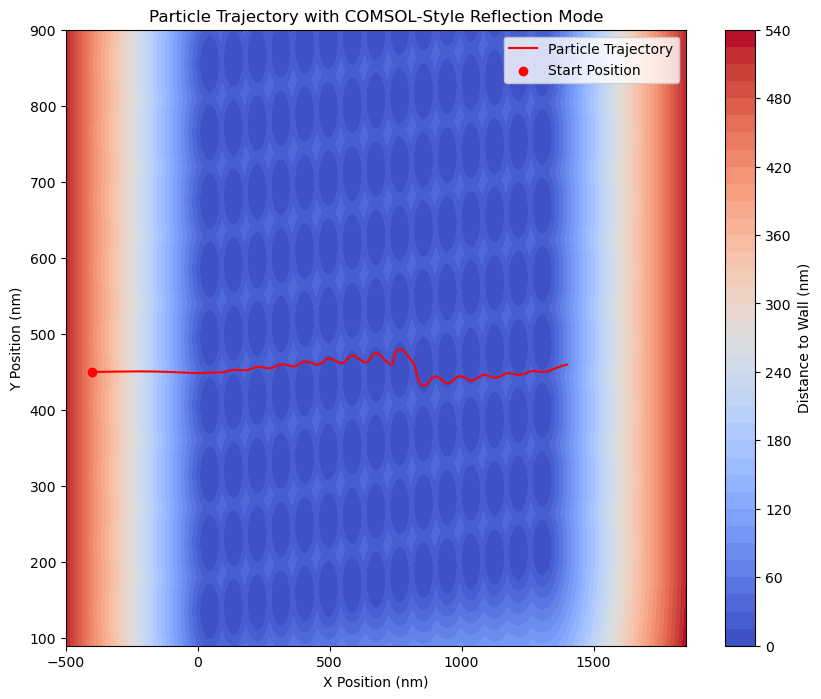

In [2]:
#i believe it got the thing right
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import LinearNDInterpolator, griddata
import pandas as pd
import time

# Define the centers and radius of the circular posts
# Define parameters
num_columns = 15
num_rows = 9
radius = 22.5  # radius in nanometers

# Initialize list for storing post centers
centers = []

# Generate centers based on the given rules
for col in range(num_columns):
    for row in range(num_rows):
        x_center = 45 + col * 90
        y_center = 135 + row * 90 + col * 6
        centers.append((x_center, y_center))



radius_of_particle = 4.4
y_s = radius + radius_of_particle
wall_distance_threshold = radius_of_particle  # Set the wall distance threshold as a variable


# Create a grid to compute distances
x_range = np.linspace(-500, 1850, 1000)
y_range = np.linspace(90, 900, 1000)
X, Y = np.meshgrid(x_range, y_range)

# Calculate the distance from each point in the grid to the nearest circular post
distances = np.full_like(X, np.inf, dtype=float)  # initialize with infinity

for cx, cy in centers:
    distance_to_post = np.sqrt((X - cx)**2 + (Y - cy)**2) - radius
    distances = np.minimum(distances, distance_to_post)  # take the minimum distance

# Set negative distances to zero
distances = np.maximum(distances, 0)

# Calculate the gradient of the wall distance function
dy, dx = np.gradient(distances, y_range, x_range)

# Calculate the magnitude of the gradient (surface normal)
gradient_magnitude = np.sqrt(dx**2 + dy**2)

# Initialize normal_x and normal_y with zeros
normal_x = np.zeros_like(dx)
normal_y = np.zeros_like(dy)

# Avoid division by zero by normalizing only where gradient_magnitude is not zero
non_zero_magnitude = gradient_magnitude > 0
normal_x[non_zero_magnitude] = dx[non_zero_magnitude] / gradient_magnitude[non_zero_magnitude]
normal_y[non_zero_magnitude] = dy[non_zero_magnitude] / gradient_magnitude[non_zero_magnitude]

# Create LinearNDInterpolators for wall distance and normals
wall_distance_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), distances.ravel(), fill_value=np.inf)
normal_x_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), normal_x.ravel(), fill_value=0)
normal_y_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), normal_y.ravel(), fill_value=0)

# Load the particle velocity data
file_path = r"C:\Users\mahir\OneDrive\Desktop\wholeDLD.csv"
velocity_field_data = pd.read_csv(file_path)

x = velocity_field_data['x'].values
y = velocity_field_data['y'].values
u = velocity_field_data['uu'].values
v = velocity_field_data['vv'].values

# Normalize the velocity components
maxu = np.max(np.abs(u))
maxv = np.max(np.abs(v))
max_vel = max(maxu, maxv)

# Create LinearNDInterpolator for U and V fields
u_interp = LinearNDInterpolator(list(zip(x, y)), u / max_vel)  # Normalize during interpolation setup
v_interp = LinearNDInterpolator(list(zip(x, y)), v / max_vel)

def velocity(x, y, u_interp, v_interp):
    """Interpolate velocity at the particle's position."""
    u = u_interp(x, y)
    v = v_interp(x, y)
    return u, v

def rk4_step(x, y, dt, u, v):
    """Calculate the next position of the particle using RK4 with provided velocity components."""
    # k1
    k1x = dt * u
    k1y = dt * v

    # k2
    u2, v2 = velocity(x + k1x / 2, y + k1y / 2, u_interp, v_interp)
    k2x = dt * u2
    k2y = dt * v2

    # k3
    u3, v3 = velocity(x + k2x / 2, y + k2y / 2, u_interp, v_interp)
    k3x = dt * u3
    k3y = dt * v3

    # k4
    u4, v4 = velocity(x + k3x, y + k3y, u_interp, v_interp)
    k4x = dt * u4
    k4y = dt * v4

    # Combine increments to get the next position
    x_next = x + (k1x + 2 * k2x + 2 * k3x + k4x) / 6
    y_next = y + (k1y + 2 * k2y + 2 * k3y + k4y) / 6

    return x_next, y_next

# Initial position of the particle
x0, y0 = -400, 450  # Starting at x=0, y=142.5
dt = 0.1  # Time step

# Lists to store the particle's trajectory and wall distance
x_traj = [x0]
y_traj = [y0]
wall_distances = []  # To store the wall distance after each iteration

# Start timer for simulation
start_time = time.time()

# Initialize the initial velocity
u, v = velocity(x0, y0, u_interp, v_interp)

# Simulate the particle trajectory with COMSOL-like reflection mode
i = 0
while x_traj[-1] < 1400 and y_traj[-1] > 0.01:
    x_next, y_next = rk4_step(x_traj[-1], y_traj[-1], dt, u, v)
    
    # Interpolate wall distance at the new position
    distance_to_wall = wall_distance_interp(x_next, y_next)
    wall_distances.append(distance_to_wall)  # Append the wall distance to the list
    
    # Check if particle hits the wall (distance <= wall_distance_threshold)
    if distance_to_wall <= wall_distance_threshold:
        # Get the normal vector at the point of collision
        nx = normal_x_interp(x_next, y_next)
        ny = normal_y_interp(x_next, y_next)
        
        # Reflect the velocity according to the COMSOL-style bounce model
        # Calculate the incident angle and reflect the velocity across the normal
        dot_product = u * nx + v * ny
        u = u - 2 * dot_product * nx
        v = v - 2 * dot_product * ny
        
        # Move the particle to exactly wall_distance_threshold away from the wall along the normal direction
        x_next = x_next + (wall_distance_threshold - distance_to_wall) * nx
        y_next = y_next + (wall_distance_threshold - distance_to_wall) * ny
        
        # Update distance to ensure it's precisely at the threshold after moving
        distance_to_wall = wall_distance_interp(x_next, y_next)
    else:
        u, v = velocity(x_next, y_next, u_interp, v_interp)
        
    
    # Append the updated position after reflection if necessary
    x_traj.append(x_next)
    y_traj.append(y_next)

    # Print position and wall distance every 100 iterations
    i += 1
    if i % 100 == 0:
        print(f"Iteration {i}: Position (x, y) = ({x_next:.2f}, {y_next:.2f}), Wall Distance = {distance_to_wall:.2f} nm")

# End timer for simulation
end_time = time.time()
total_time = end_time - start_time
print(f"Total simulation time: {total_time:.2f} seconds")

# Plot the results
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, distances, levels=50, cmap='coolwarm')
plt.colorbar(label='Distance to Wall (nm)')
plt.plot(x_traj, y_traj, 'r-', label='Particle Trajectory')
plt.scatter([x0], [y0], color='red', label='Start Position')
plt.xlabel('X Position (nm)')
plt.ylabel('Y Position (nm)')
plt.legend()
plt.title('Particle Trajectory with COMSOL-Style Reflection Mode')
plt.show()



Iteration 100: Position (x, y) = (-396.74, 450.02), Wall Distance = 421.52 nm
Iteration 200: Position (x, y) = (-393.47, 450.03), Wall Distance = 418.27 nm
Iteration 300: Position (x, y) = (-390.21, 450.05), Wall Distance = 415.02 nm
Iteration 400: Position (x, y) = (-386.94, 450.07), Wall Distance = 411.77 nm
Iteration 500: Position (x, y) = (-383.67, 450.09), Wall Distance = 408.51 nm
Iteration 600: Position (x, y) = (-380.39, 450.11), Wall Distance = 405.25 nm
Iteration 700: Position (x, y) = (-377.11, 450.13), Wall Distance = 401.99 nm
Iteration 800: Position (x, y) = (-373.84, 450.15), Wall Distance = 398.73 nm
Iteration 900: Position (x, y) = (-370.55, 450.17), Wall Distance = 395.47 nm
Iteration 1000: Position (x, y) = (-367.27, 450.18), Wall Distance = 392.20 nm
Iteration 1100: Position (x, y) = (-363.98, 450.20), Wall Distance = 388.93 nm
Iteration 1200: Position (x, y) = (-360.69, 450.22), Wall Distance = 385.66 nm
Iteration 1300: Position (x, y) = (-357.40, 450.24), Wall Dis

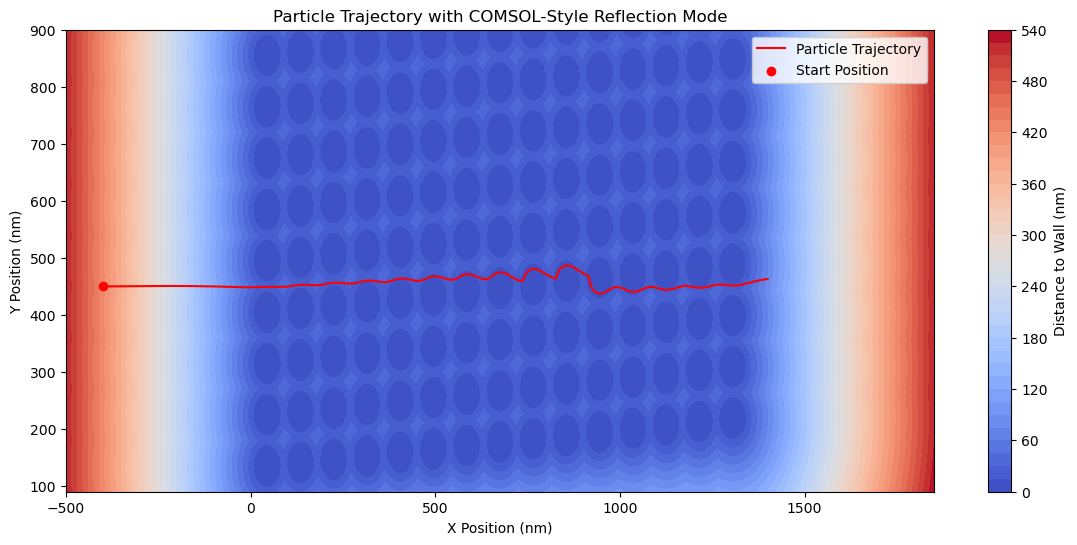

In [5]:
radius_of_particle = 5
y_s = radius + radius_of_particle
wall_distance_threshold = radius_of_particle  # Set the wall distance threshold as a variable

def velocity(x, y, u_interp, v_interp):
    """Interpolate velocity at the particle's position."""
    u = u_interp(x, y)
    v = v_interp(x, y)
    return u, v

def rk4_step(x, y, dt, u, v):
    """Calculate the next position of the particle using RK4 with provided velocity components."""
    # k1
    k1x = dt * u
    k1y = dt * v

    # k2
    u2, v2 = velocity(x + k1x / 2, y + k1y / 2, u_interp, v_interp)
    k2x = dt * u2
    k2y = dt * v2

    # k3
    u3, v3 = velocity(x + k2x / 2, y + k2y / 2, u_interp, v_interp)
    k3x = dt * u3
    k3y = dt * v3

    # k4
    u4, v4 = velocity(x + k3x, y + k3y, u_interp, v_interp)
    k4x = dt * u4
    k4y = dt * v4

    # Combine increments to get the next position
    x_next = x + (k1x + 2 * k2x + 2 * k3x + k4x) / 6
    y_next = y + (k1y + 2 * k2y + 2 * k3y + k4y) / 6

    return x_next, y_next

# Initial position of the particle
x0, y0 = -400, 450  # Starting at x=0, y=142.5
dt = 0.1  # Time step

# Lists to store the particle's trajectory and wall distance
x_traj = [x0]
y_traj = [y0]
wall_distances = []  # To store the wall distance after each iteration

# Start timer for simulation
start_time = time.time()

# Initialize the initial velocity
u, v = velocity(x0, y0, u_interp, v_interp)

# Simulate the particle trajectory with COMSOL-like reflection mode
i = 0
while x_traj[-1] < 1400 and y_traj[-1] > 0.01:
    x_next, y_next = rk4_step(x_traj[-1], y_traj[-1], dt, u, v)
    
    # Interpolate wall distance at the new position
    distance_to_wall = wall_distance_interp(x_next, y_next)
    wall_distances.append(distance_to_wall)  # Append the wall distance to the list
    
    # Check if particle hits the wall (distance <= wall_distance_threshold)
    if distance_to_wall <= wall_distance_threshold:
        # Get the normal vector at the point of collision
        nx = normal_x_interp(x_next, y_next)
        ny = normal_y_interp(x_next, y_next)
        
        # Reflect the velocity according to the COMSOL-style bounce model
        # Calculate the incident angle and reflect the velocity across the normal
        dot_product = u * nx + v * ny
        u = u - 2 * dot_product * nx
        v = v - 2 * dot_product * ny
        
        # Move the particle to exactly wall_distance_threshold away from the wall along the normal direction
        x_next = x_next + (wall_distance_threshold - distance_to_wall) * nx
        y_next = y_next + (wall_distance_threshold - distance_to_wall) * ny
        
        # Update distance to ensure it's precisely at the threshold after moving
        distance_to_wall = wall_distance_interp(x_next, y_next)
    else:
        u, v = velocity(x_next, y_next, u_interp, v_interp)
        
    
    # Append the updated position after reflection if necessary
    x_traj.append(x_next)
    y_traj.append(y_next)

    # Print position and wall distance every 100 iterations
    i += 1
    if i % 100 == 0:
        print(f"Iteration {i}: Position (x, y) = ({x_next:.2f}, {y_next:.2f}), Wall Distance = {distance_to_wall:.2f} nm")

# End timer for simulation
end_time = time.time()
total_time = end_time - start_time
print(f"Total simulation time: {total_time:.2f} seconds")

# Plot the results
plt.figure(figsize=(14, 6))
plt.contourf(X, Y, distances, levels=50, cmap='coolwarm')
plt.colorbar(label='Distance to Wall (nm)')
plt.plot(x_traj, y_traj, 'r-', label='Particle Trajectory')
plt.scatter([x0], [y0], color='red', label='Start Position')
plt.xlabel('X Position (nm)')
plt.ylabel('Y Position (nm)')
plt.legend()
plt.title('Particle Trajectory with COMSOL-Style Reflection Mode')
plt.show()